--------------------------------------------------------------------
ER background from materials. 
----------------------------------------------------------------
notebook can be run on the Freiburg cluster or on Dali. 
Change the path of files accordingly.
on dali files are on: /dali/lgrandi/xenonnt/simulations/er_simulations/rootfiles

In [62]:
print("loading....")
%run 'init.ipynb'
%run 'geometry_checks.ipynb'
%run 'functions.ipynb'
print("done!")


loading....
server chosen is: /userdata/arocchetti/rootfiles/
done!


In [98]:
#list of components and isotopes used in this analysis.

components = ["PmtTpc",
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "Teflon_Pillar_",#includes also pfte frame (Lxe + Gxe part)
             "SS_AnodeRing", #anode + all the electrodes 
             "Teflon_TPC_Sliding", #material is Teflon_TPC used twice for sliding and fixed
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             "Copper_TopRing", #includes also bottom ring
             "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Copper_BottomPmtPlate" #includes also top ring
             ]

isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]

In [93]:
def do(component, m_fv): 
    #main function to calculate the rate
    conv = 3.15*1e7 #conversion factor s->y
    rate_array = []
    error_array = []
    i = 0
    flag = 0
    total_str = ""  
    E = 11
    time_array = []
  
    for i in range(0, len(isotope_array)):
        note = " "
        isotope = isotope_array[i]
        data, frac, material = get_data(isotope, component) 
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #return the normalization for the isotope chains
        n =  N*(frac/100)*(1/b) #n_gen * fraction events in that component * chain_factor
        
        n_events = calculate_events(data, isotope)
 
        #print("---", isotope, n, N, frac, n_events, b )
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]/1000 #mBq->Bq
        contamination = p[isotope]/1000 
        if error_cont == 0:
            note = "*"
        else:
            note = " "
        if (contamination == 0):
            rate = 0
            error_rate = 0
            str_ = ( "| no contamination value ")
            alpha = 0
            time = 0

        else:
#             contamination = p[isotope]/1000 
            time = n / (mass * contamination)
            #print("----", isotope, time/conv)
            rate = n_events/(time * m_fv ) #*E  #ev/s*kg
            alpha = mass / (m_fv * n) #correct with mass*b/(m_fv*E*N_gen)  ##no energy   
            error_rate = alpha * np.sqrt((n_events * error_cont)**2 + (contamination*np.sqrt(n_events))**2)
                       
            if n_events == 2.3: 
                str_ = ("| <%2.2g" %(rate*conv)) + note
                flag = flag +1
            else:
                str_ = ("|(%2.2g +- %2.2g)" %(rate*conv, error_rate*conv))+ note 
            
        rate_array = np.append(rate_array, rate)
        error_array = np.append(error_array, error_rate) 
        total_str = total_str  + str_ 
        if time == 0:
            time_array = time_array = np.append(time_array, time)  
        else:
            time_array = time_array = np.append(time_array, time/conv)
        
        i = i+1 
        tot_rate = 0
        tot_error_rate = 0
        if len(rate_array)!=0:
            for i in range(0, len(rate_array)):
                tot_rate = tot_rate + rate_array[i]
                tot_error_rate = tot_error_rate + error_array[i]
                if flag == 0:
                    total_rate_string = ("|(**%2.2g +- %2.2g)" %(tot_rate*conv, tot_error_rate*conv)+ "**|" )
                else:
                    total_rate_string = ("|**<%2.2g " %(tot_rate*conv)+ "**|") 
        else:
            total_rate_string = "|"        
    print("|" + component + total_str + total_rate_string)
    return tot_rate*conv, time_array
    
####################################################################################


In [94]:
#Cell calculates the rate for the Cryostats
m_fv = 4
components = [
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)
    print("^Tot.^^^^^^^^^", "%.2g" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 


^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|OuterCryostat_Elongation|(0.17 +- 0.53) |(0.086 +- 0.066) |(0.04 +- 0.068) |(0.00028 +- 0.0009) |(0.066 +- 0.15) | <0.64*|(0.025 +- 0.11) |(1.3 +- 1.2) |**<2.4 **|
|OuterCryostatShell| <2.3 |(7.2 +- 2.5) |(0.22 +- 0.22)*|(0.024 +- 0.035)*|(0.21 +- 0.21)*| <0.23 |(0.052 +- 0.069) |(1.4 +- 0.82)*|**<12 **|


KeyboardInterrupt: 

NameError: name 'alpha' is not defined

In [ ]:
#----------BELL----------------
components = [
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^


In [ ]:
#-----------Teflon ----------------
components = [
             "Teflon_Pillar_",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

In [ ]:
#-----------Copper ----------------
components = [
             "Copper_TopRing",
             "Copper_FieldGuard_",
             "Copper_FieldShaperRing_",
             "Copper_BottomPmtPlate"
             ]


#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

In [ ]:
#----------- Others ----------------
components = ["PmtTpc",
             "SS_AnodeRing",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv)

In [ ]:
# PLOTS

In [ ]:
#plot cryostat
components = [
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             ]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "Cryostat")

In [ ]:
#plot Bell
components = [
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             ]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "Bell")

In [ ]:
#plot Teflon
components = [
             "Teflon_Pillar_",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             ]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "Teflon")

In [ ]:
#plot Copper
components = [
             "Copper_TopRing",
             "Copper_FieldGuard_",
             "Copper_FieldShaperRing_",
             "Copper_BottomPmtPlate"
             ]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "Copper")

In [ ]:
#plot pmt
components = ["PmtTpc"]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "pmt")

In [ ]:
#plot electrodes
components = ["SS_AnodeRing"]
values, bins_plt = plot_total_contribution(500, 0, 2500 )
make_spectrum(values, "electrodes")

In [ ]:
#-----extra plots-------------

In [ ]:
components = ["PmtTpc"]
isotope_array = ["Ra226", "Th228"]
###plot spectrum per component 
def plot_spectrum_comp(data, min_,max_, bins, isotope, time):
    time_weights = [(1/time)*(864/400)]*len(data)
    m, bins_plt, = np.histogram(data.Ed, bins = bins, range = (min_, max_), weights = time_weights)            
    plt.yscale("log")              
    plt.plot(bins_plt[:-1], m, label = isotope)
    plt.ylabel('ev/kg*day*keV')
    plt.xlabel('Ed [keV]')
    plt.yscale('log')
    plt.tight_layout()
    plt.legend()
    
for component in components:
    print("working on:" , component)
    p = get_parameters(component)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        print(isotope)
        data, frac, material = get_data(isotope, component)
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #later on with the good function
        n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        if contamination > 0:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
        else:          
            print("no contamination")
        
        plot_spectrum_comp(data, 0, 2500, 250, isotope, time) 
    plt.show()

working on: PmtTpc
Ra226


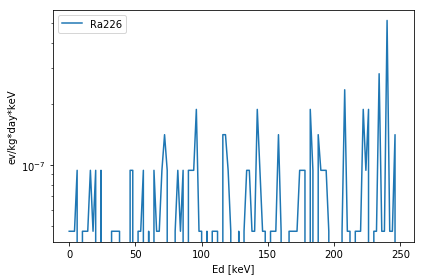

In [69]:
# same but if FV

components = ["PmtTpc"]
# isotope_array = ["Ra226", "Th228", "Co60"]
###plot spectrum per component 
def plot_spectrum_comp(data, min_,max_, bins, isotope, time):
    time_weights = [(1/time)*(864/400)]*len(data)
    m, bins_plt, = np.histogram(data.Ed, bins = bins, range = (min_, max_), weights = time_weights)            
    plt.yscale("log")              
    plt.plot(bins_plt[:-1], m, label = isotope)
    plt.ylabel('ev/kg*day*keV')
    plt.xlabel('Ed [keV]')
    plt.yscale('log')
    plt.tight_layout()
    plt.legend()
    
for component in components:
    print("working on:" , component)
    p = get_parameters(component)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        print(isotope)
        data2, frac, material = get_data(isotope, component)
        data = fv(data2)
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #later on with the good function
        n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        if contamination > 0:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
        else:          
            print("no contamination")
        
        plot_spectrum_comp(data, 0, 250, 125, isotope, time) 
    plt.show()

working on: PmtTpc
U238
Co60
K40
Cs137
Th228
U235
Th232
Ra226


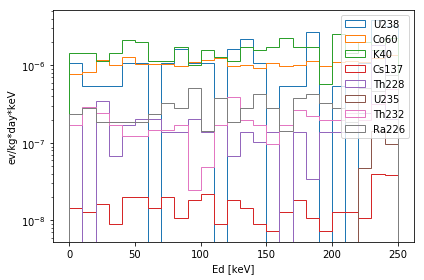

In [102]:
components = ["PmtTpc"]

###plot spectrum per component 
def plot_spectrum_comp(data, min_,max_, bins_, isotope, time):
    time_weights = (1/time)*(864/400)
    counts, bins = np.histogram(data.Ed, bins = bins_, range = (min_, max_))  
    counts1 = counts*time_weights
    plt.hist(bins[:-1], bins, weights=counts1, label = isotope, histtype = "step")
    plt.ylabel('ev/kg*day*keV')
    plt.xlabel('Ed [keV]')
    plt.yscale('log')
    plt.tight_layout()
    plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-large')
    
for component in components:
    print("working on:" , component)
    p = get_parameters(component)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        print(isotope)
        data2, frac, material = get_data(isotope, component)
        data = fv(data2)
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #later on with the good function
        n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        if contamination > 0:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
        else:          
            print("no contamination")
        
        plot_spectrum_comp(data, 0, 250, 25, isotope, time) 
    plt.show()

In [ ]:
min_ = 0
max_ = 250
bins = 25
m, bins_plt, = plt.hist(data2.Ed, bins = bins, range = (min_, max_))

In [22]:
print(m)

[458518 681072 286739 107912 108800  60405  40882  61072  20317   5602]


In [23]:
print(bins_plt)

[0.0 250.0 500.0 750.0 1000.0 1250.0 1500.0 1750.0 2000.0 2250.0 2500.0]


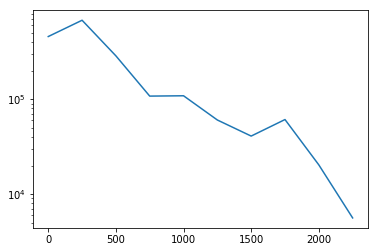

In [26]:
plt.plot(bins_plt[:-1], m)
plt.yscale('log')